### Transfer learning using CFAR10 datasets with tensorflow
reference: https://www.tensorflow.org/guide/keras/transfer_learning

importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import sklearn

It's important to determine which model is suitable for your case. There is a compromise between the model's size and its accuracy. Here is the information about the available models in keras.applications, including details related to their size, number of parameters, and accuracy.

https://keras.io/api/applications/

In this project, MobileNetV2 has been selected. For more information, please refer to the link: https://keras.io/api/applications/mobilenet/

In [2]:
img_size = 224
base_model = tf.keras.applications.MobileNetV2(
                input_shape = (img_size, img_size, 3),
                include_top = False,
                weights = 'imagenet'
                )
base_model.trainable = False # The parameters of the base_model will not be updated during training as long as base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


### Building the model

In [3]:
inputs = tf.keras.Input(shape=(32,32,3))
x = tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1.0)(inputs) # scaling from [0, 255] to [-1, -1]
x = tf.keras.layers.Resizing(img_size,img_size)(x) # resizing the input image to [img_size, img_size]
x = tf.keras.layers.RandomFlip(mode='horizontal')(x) # aumentation: horizontal random flip
x = tf.keras.layers.RandomRotation(factor = 0.2)(x) # aumentation: random rotation 0.2*(360) degrees
x = base_model(x, training = False)   # base_model in an inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x) #
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=10)(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                     

### loading CFAR10 datasets

In [4]:
batch_size = 32
val_size = 10000
classes     = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_datasets, test_datasets = tf.keras.datasets.cifar10.load_data()

# split the train datasets into train & validation datasets
val_datasets   = (train_datasets[0][:val_size], train_datasets[1][:val_size])
train_datasets = (train_datasets[0][val_size:], train_datasets[1][val_size:])

# shuffle, bactch, cache & prefetch the datasets
train_datasets = tf.data.Dataset.from_tensor_slices(train_datasets).shuffle(train_datasets[0].shape[0]).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_datasets   = tf.data.Dataset.from_tensor_slices(val_datasets).shuffle(val_datasets[0].shape[0]).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_datasets  = tf.data.Dataset.from_tensor_slices(test_datasets).batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

170498071/170498071 [==============================] - 5s 0us/step


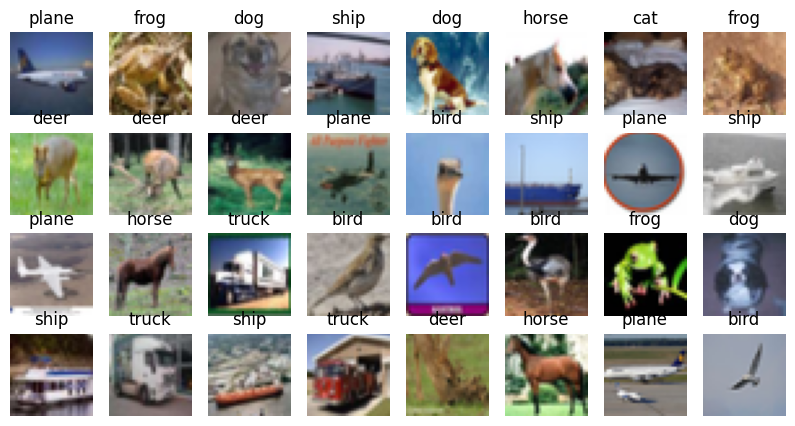

In [5]:
plt.figure(figsize=(10,5))

for X, y in train_datasets.take(1):
  for idx in range(32):
    plt.subplot(4, 8,idx+1)
    plt.imshow(X[idx])
    plt.title(classes[int(y[idx])])
    plt.axis('off')


#### callback

In [6]:
class Callback(tf.keras.callbacks.Callback):
    def __init__(self, val_accuracy):
        self.val_accuracy = val_accuracy;
    def on_epoch_end(self, epoch, logs = None):
        if logs.get("val_sparse_categorical_accuracy", 0) >= self.val_accuracy:
            print("training is stopped: validation accuracy is > ", self.val_accuracy)
            self.model.stop_training = True

#### optimizer, loss & metrics

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
              )


#### model fit

In [8]:
model.fit(
    train_datasets,
    epochs =10,
    # steps_per_epoch = 500,
    validation_data = val_datasets,
    # validation_steps = 100,
    callbacks = [Callback(val_accuracy=0.95)]
    )

Epoch 1/10
1250/1250 [==============================] - 68s 48ms/step - loss: 1.2153 - sparse_categorical_accuracy: 0.5728 - val_loss: 0.6297 - val_sparse_categorical_accuracy: 0.7877
Epoch 2/10
1250/1250 [==============================] - 57s 46ms/step - loss: 1.0279 - sparse_categorical_accuracy: 0.6439 - val_loss: 0.5816 - val_sparse_categorical_accuracy: 0.8049
Epoch 3/10
1250/1250 [==============================] - 57s 46ms/step - loss: 0.9908 - sparse_categorical_accuracy: 0.6591 - val_loss: 0.5729 - val_sparse_categorical_accuracy: 0.8083
Epoch 4/10
1250/1250 [==============================] - 58s 46ms/step - loss: 0.9657 - sparse_categorical_accuracy: 0.6629 - val_loss: 0.5798 - val_sparse_categorical_accuracy: 0.8041
Epoch 5/10
1250/1250 [==============================] - 57s 46ms/step - loss: 0.9397 - sparse_categorical_accuracy: 0.6752 - val_loss: 0.5375 - val_sparse_categorical_accuracy: 0.8170
Epoch 6/10
1250/1250 [==============================] - 57s 45ms/step - loss: 0.

#### fine-tuning

In [9]:
base_model.trainable = True # updating the base_model parameters
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # small learning_rate
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
                     )
model.fit(
    train_datasets,
    epochs =10,
    # steps_per_epoch = 500,
    validation_data = val_datasets,
    # validation_steps = 100,
    callbacks = [Callback(val_accuracy=0.95)] )

Epoch 1/10
1250/1250 [==============================] - 213s 149ms/step - loss: 0.8452 - sparse_categorical_accuracy: 0.7172 - val_loss: 0.4926 - val_sparse_categorical_accuracy: 0.8423
Epoch 2/10
1250/1250 [==============================] - 186s 149ms/step - loss: 0.5923 - sparse_categorical_accuracy: 0.8073 - val_loss: 0.4004 - val_sparse_categorical_accuracy: 0.8725
Epoch 3/10
1250/1250 [==============================] - 186s 148ms/step - loss: 0.5038 - sparse_categorical_accuracy: 0.8352 - val_loss: 0.2967 - val_sparse_categorical_accuracy: 0.9018
Epoch 4/10
1250/1250 [==============================] - 185s 148ms/step - loss: 0.4437 - sparse_categorical_accuracy: 0.8528 - val_loss: 0.3699 - val_sparse_categorical_accuracy: 0.8706
Epoch 5/10
1250/1250 [==============================] - 185s 148ms/step - loss: 0.4078 - sparse_categorical_accuracy: 0.8662 - val_loss: 0.3194 - val_sparse_categorical_accuracy: 0.8934
Epoch 6/10
1250/1250 [==============================] - 186s 148ms/ste

### evaluation

In [10]:
model.evaluate(test_datasets)

313/313 [==============================] - 11s 35ms/step - loss: 0.2793 - sparse_categorical_accuracy: 0.9133


[0.2793351709842682, 0.9132999777793884]

#### plot the prediction

In [11]:
y_pred = model.predict(test_datasets)

313/313 [==============================] - 11s 33ms/step


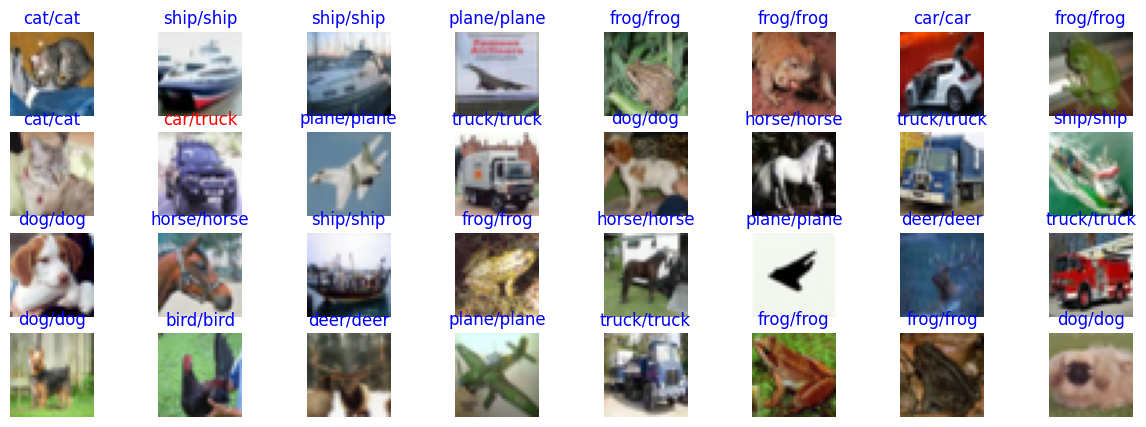

In [13]:
plt.figure(figsize=(15,5))

for X, y in test_datasets.take(1):
  for idx in range(32):
    plt.subplot(4, 8,idx+1)
    plt.imshow(X[idx])
    y_pred_idx = int(np.argmax(y_pred[idx]))
    if int(y[idx]) == np.argmax(y_pred[idx]).astype(int):
      plt.title("{}/{}".format(classes[int(y[idx])], classes[y_pred_idx]), color = 'blue')
    else:
      plt.title("{}/{}".format(classes[int(y[idx])], classes[y_pred_idx]), color = 'red')
    plt.axis('off')